In [2]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
from __future__ import print_function
import tensorflow.keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.callbacks import *
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# The below code allows us to import functions from python files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

vis_tools = drive.CreateFile({'id':'1Pj2xsMXrEUgSjdJ65jecC5WXB2jy5sw8'})
vis_tools.GetContentFile('VisualisationTools.py')
import VisualisationTools
plot_losses = VisualisationTools.PlotLearning()

TensorFlow is already loaded. Please restart the runtime to change versions.
1.15.0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import cv2
import glob

path = "/content/gdrive/My Drive/Deepfakes Capstone Project"

def get_images(path):
  '''Outputs a list images in a speficied path
  Resizes images to all be the same size (for now 32x32)'''

  image_data_list = []
  ori_count=0
  for i in ['original_sequences', 'manipulated_sequences']:
    for j in glob.glob(path + '/' + i + '/*'):
      for each_img in glob.glob(j + '/*'):
        input_img = cv2.imread(each_img)
        input_img_resize=cv2.resize(input_img,(71,71)) # for future modification
        image_data_list.append(input_img_resize)
        if i=='original_sequences':
          ori_count+=1
    
  return np.array(image_data_list), ori_count

x_data, ori_count = get_images(path)

In [0]:
# Save image tensors to disk
import pickle
with open(path + '/image_tensors.pickle', 'wb') as handle:
    pickle.dump(x_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(path + '/image_tensors.pickle', 'rb') as handle:
#     x_data = pickle.load(handle)

In [0]:
# Specify the parameters and process the data
batch_size = 32

# Normalise data for all neural nets to follow
x_data = x_data.astype('float32')
x_data /= 255
manip_count = x_data.shape[0]-ori_count
y_data = np.append(np.array([0]*ori_count), np.array([1]*manip_count))
y_data.shape
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33)
y_train = tf.keras.utils.to_categorical(y_train, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)

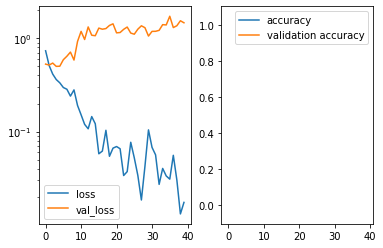

1037/1037 [==============================] - 4s 4ms/sample - loss: 0.0175 - acc: 0.9942 - val_loss: 1.4677 - val_acc: 0.7793
512/512 - 0s - loss: 1.4677 - acc: 0.7793
Restored model trained further, accuracy: 77.93%


In [12]:
# Train all parameters of ResNet
from tensorflow.keras.applications.xception import Xception

conv_base = Xception(weights='imagenet', include_top=False,
                     input_shape=(71, 71, 3))
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Save weights
filepath="/content/gdrive/My Drive/Deepfakes Capstone \
Project/SavedWeights/Xception/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')

# # Load weights
# model.load_weights("/content/gdrive/My Drive/Deepfakes Capstone \
# Project/SavedWeights/ResNetAllLayers/epochs:024-val_acc:0.748.hdf5")

# NEED TO USE THE LEARNING RATE SCHEDULER BELOW
# ALSO ADD A GLOBAL AVERAGE POOLING LAYER WHICH WILL BE LESS EXPENSIVE THAN
# A DENSE LAYER AT THE END BUT WILL WORK AS WELL
# lr decay function
# def lr_decay(epoch):
#   return 0.01 * math.pow(0.6, epoch)

# # lr schedule callback
# lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# # important to see what you are doing
# plot_learning_rate(lr_decay, EPOCHS)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=40,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=[plot_losses, checkpoint], # maybe add callbacks_list here
          verbose=1)

loss, acc = model.evaluate(x_test,  y_test, verbose=2)
print("Restored model trained further, accuracy: {:5.2f}%".format(100*acc))